In [2]:
import sys
sys.path.append('/mnt/disk05/note/workspaces/duxx')
from feature_selector import FeatureSelector
from unity import init_pkg as ini
from unity.eda_func import EdaFunc as edf
from unity.fea_eda_func import FeaEdaFunc as fef
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
import os
import json
import datetime
import gc
import scorecardpy as sc
# import pandas_profiling

% matplotlib inline

In [3]:
bdbank = ini.pd.read_pickle('data/bd/bdbank.pkl')
bdtag = ini.pd.read_csv('data/tag/bd_tag_avli.csv')

In [4]:
bdbank.columns

Index(['ID', 'CUST_NAME', 'ID_CARD_NO', 'MOBILE_NO', 'BANK_CARD_NO',
       'CREATED_DATE', 'UPDATED_DATE', 'TRANSACTION_TYPE', 'TRANSACTION_ID',
       'ORDER_NO',
       ...
       'zxRcy6MLoanQueryCompanyCnt', 'zxRcyQueryDate', 'zxRestDisposalCnt',
       'zxSex', 'zxTotalCreditAmt', 'zxUseCreditAmt', 'zxWarrantLoanCnt',
       'zxWarrantLoanRate1', 'zxWarrantLoanType', 'zxWarrantLoanTypeUnnormal'],
      dtype='object', length=140)

In [158]:
bdtag.head()

,dubil_no,cert_no,ovdue_days,lon_dt
0,4176499214121897291,350521197206100033,0,2020-04-02
1,4176498286408975032,640321198510110730,0,2020-03-29
2,4170320439806389279,12022219960310582X,0,2020-03-26
3,4149489607891218124,441623199705305789,0,2020-03-23
4,4176499660798518798,110102197111170818,0,2020-04-02


In [4]:
bdtag['tag'] = 0
bdtag.loc[bdtag['ovdue_days']>30,'tag'] = 1

In [5]:
bdbank = bdbank.sort_values(['ID_CARD_NO','CREATED_DATE'],ascending=[0,1]).drop_duplicates('ID_CARD_NO',keep='first')

In [164]:
bdmain.shape

(69422, 144)

In [6]:
bdbank = bdbank.dropna(subset=['ID','ID_CARD_NO'])
bdbank = bdbank.rename({'ID_CARD_NO':'cert_no'},axis=1)
bdmain = bdbank.merge(bdtag,on='cert_no')
del bdbank,bdtag

# 一、数据清洗

## 1.1 剔除单一值、缺失>0.7、相关性>0.7

In [7]:
drop_feas = {'ID','BANK_CARD_NO','MOBILE_NO','TRANSACTION_ID','CUST_NAME','ORDER_NO','idpicture0','livingPhoto',
             'photowithidcard','orderId','CREATED_DATE','reasonMsg','unionLoanUsed','TRANSACTION_TYPE','zxSex',
             'TRANSACTION_ID','ovdue_days','BANK_CARD_NO','dubil_no','UPDATED_DATE','zxDomicile','zxPermanentAddress'}

bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

In [8]:
fs = FeatureSelector(data=bdmain.drop('tag',axis=1),labels=bdmain['tag'])
fs.identify_missing(0.7)
fs.identify_single_unique()
fs.identify_collinear(0.7)
fs_drop = fs.check_removal()

38 features with greater than 0.70 missing values.

7 features with a single unique value.

0 features with a correlation magnitude greater than 0.70.

Total of 45 features identified for removal


In [59]:
drop_feas = drop_feas | set(fs_drop)

In [60]:
bdmain = bdmain.drop(drop_feas,axis=1)

In [14]:
bdmain['zxGuaranteeCnt'].unique()

array(['-9999', nan, '1'], dtype=object)

## 1.2 异常值处理

In [95]:
# bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

## 1.3 划分数据集

In [119]:
train_x,test_x,train_y,test_y = train_test_split(bdmain,bdmain['tag'],test_size=0.3,shuffle=True,random_state=123)

In [97]:
train_x['tag'].value_counts()

0    48144
1      451
Name: tag, dtype: int64

In [98]:
test_x['tag'].value_counts()

0    20631
1      196
Name: tag, dtype: int64

# 二、特征工程

## 2.1 日期、百分比、地址特征处理

### 2.1.1 日期特征衍生

In [120]:
date_feas = train_x.loc[:,train_x.columns.str.contains('Date|LastMonth|lon_dt|FirstLoan|Update')].columns

In [17]:
date_feas

Index(['zxCreditCardRcyDelqDate', 'zxCreditCardRcyUpdateDate',
       'zxFirstCreCardDate', 'zxFirstLoanDate', 'zxFirstLoanMonth',
       'zxHouseFundPayLastMonth', 'zxHouseFundRecordUpdate',
       'zxLoanRcyDelqDate', 'zxLoanRcyUpdateDate', 'zxMaxUpdated',
       'zxRcyQueryDate', 'lon_dt'],
      dtype='object')

In [18]:
train_x[date_feas].dtypes

zxCreditCardRcyDelqDate      object
zxCreditCardRcyUpdateDate    object
zxFirstCreCardDate           object
zxFirstLoanDate              object
zxFirstLoanMonth             object
zxHouseFundPayLastMonth      object
zxHouseFundRecordUpdate      object
zxLoanRcyDelqDate            object
zxLoanRcyUpdateDate          object
zxMaxUpdated                 object
zxRcyQueryDate               object
lon_dt                       object
dtype: object

In [121]:
train_x['zxHouseFundPayLastMonth'] = train_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
test_x['zxHouseFundPayLastMonth'] = test_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
train_x.loc[:,date_feas] = train_x[date_feas].astype('datetime64[ns]')
test_x.loc[:,date_feas] = test_x[date_feas].astype('datetime64[ns]')

In [122]:
for c in date_feas[:-1]:
    train_x[f'{c}_diff_londt'] = abs((train_x['lon_dt'] - train_x[c]).dt.days)
    test_x[f'{c}_diff_londt']  = abs((test_x['lon_dt'] - test_x[c]).dt.days)

In [123]:
train_x = train_x.drop(date_feas,axis=1)
test_x = test_x.drop(date_feas,axis=1)

### 2.1.2 比例特征处理

In [124]:
train_x['zxHouseFundCompanyRate'] = train_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
train_x['zxHouseFundSelfRate'] = train_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundCompanyRate'] = test_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundSelfRate'] = test_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100

### 2.1.3 地址特征处理

In [125]:
train_x = fef.build_cert_refer_feas(train_x,cert_cols='cert_no')
test_x = fef.build_cert_refer_feas(test_x,cert_cols='cert_no')

## 2.2 类别特征处理

In [68]:
def bin_group_single(df, col, target):
    """
    单个特征iv,woe
    """
    regroup = df.groupby([col])['tag'].agg(['count','sum']).replace(0,0.9)\
                .rename({'count':'total','sum':'bad'},axis=1)\
                .assign(variable=col,
                        good=lambda x:x['total']-x['bad'],
                        badprob = lambda x:x['bad']/x['total'],
                        DistrBad = lambda x:x['good']/sum(x['good']),
                        DistrGood = lambda x:x['bad']/sum(x['bad']),
                        woe = lambda x:ini.np.log(x['DistrBad']/x['DistrGood']),
                        bin_iv = lambda x:(x['DistrBad']-x['DistrGood'])*x['woe'],
                        total_iv = lambda x:sum(x.bin_iv))
    regroup.reset_index(level=0,inplace=True)
    return regroup

def bin_group(df, cols, target,return_type='badrate',missing=True):
    """
    """
    bin_df_dicts = {}
    if missing: df.loc[:,cols] = df.fillna('missing')
    for c in cols:
        bin_df = bin_group_single(df,c,target)
        bin_df_dicts[c] = bin_df
    return bin_df_dicts

def badrate_ply(df,cols, bin_df_dicts,missing=True):
    """
    badrate编码转化
    """
    if missing: df.loc[:,cols] = df.fillna('missing')
    bin_badp_dicts = {c:dict(zip(bin_df_dicts[c][c],bin_df_dicts[c]['badprob'])) for c in cols}
    df.replace(bin_badp_dicts,inplace=True)
    return df

In [126]:
train_x = train_x.loc[:,train_x.columns.str.contains('zx|tag')]
test_x = test_x.loc[:,test_x.columns.str.contains('zx|tag')]

In [127]:
cat_feas = set(train_x.loc[:,train_x.columns.str.contains('Status|Type|Code|Sex|Seg|LoanUse|Section|ocr|Edu|Career|Mari')].columns)

In [128]:
cat_feas_info = edf.get_features_type(train_x[cat_feas])['cat_feas']

In [34]:
cat_feas_info

zxEducation                           8
zxCreditRetCode                       3
zxCreditCardDelqStatus90To180Days    13
zxHouseFundPayStatus                  4
zxCreCardStatus4                      5
zxLoanDelqStatus30To60Days           14
zxCreditCardDelqStatus24Months       13
zxCareer                             10
zxCreditCardDelqStatus60To90Days     13
zxCreditCardDelqStatus6To12Months    13
zxLoanDelqStatus60To90Days           14
zxCreditCardDelqStatus30Dayyues      12
zxLoanDelqStatus6To12Months          12
zxWarrantLoanTypeUnnormal             3
zxCreCardStatus3                      6
zxCreditCardDelqStatus30To60Days     13
zxCreCardStatus1                      7
zxMaritalStatus                       5
zxCreCardStatus5                      7
zxLoanDelqStatus30Dayyues            10
zxLoanDelqStatus90To180Days          14
zxWarrantLoanType                     7
dtype: int64

### 2.2.1 类别  < 6 的特征直接label_encode

In [140]:
# labelencode_feas = cat_feas_info[cat_feas_info < 6].index
labelencode_feas = cat_feas_info.index

In [130]:
for f in labelencode_feas:
    label_trans = LabelEncoder()
    label_trans.fit(train_x[f])
    train_x[f] = label_trans.transform(train_x[f])
    test_x[f] = label_trans.transform(test_x[f])

In [74]:
lab_bin_dicts = bin_group(train_x,labelencode_feas,'tag')

### 2.2.2 类别 >= 6 的特征badrate_encode

In [75]:
badencode_feas = cat_feas_info[cat_feas_info >= 6].index

In [48]:
badencode_feas

Index(['zxEducation', 'zxCreditCardDelqStatus90To180Days',
       'zxLoanDelqStatus30To60Days', 'zxCreditCardDelqStatus24Months',
       'zxCareer', 'zxCreditCardDelqStatus60To90Days',
       'zxCreditCardDelqStatus6To12Months', 'zxLoanDelqStatus60To90Days',
       'zxCreditCardDelqStatus30Dayyues', 'zxLoanDelqStatus6To12Months',
       'zxCreCardStatus3', 'zxCreditCardDelqStatus30To60Days',
       'zxCreCardStatus1', 'zxCreCardStatus5', 'zxLoanDelqStatus30Dayyues',
       'zxLoanDelqStatus90To180Days', 'zxWarrantLoanType'],
      dtype='object')

In [76]:
badp_bin_dicts = bin_group(train_x,badencode_feas,'tag')
train_x = badrate_ply(train_x,badencode_feas,badp_bin_dicts)
test_x = badrate_ply(test_x,badencode_feas,badp_bin_dicts)

## 2.3 连续特征分箱

In [131]:
ext_cat_feas = set(cat_feas_info[cat_feas_info < 6].index)

In [132]:
num_feas = list(set(train_x.columns)-ext_cat_feas - {'tag'})

In [133]:
train_x.loc[:,num_feas] = train_x[num_feas].astype(float)

In [134]:
num_feas_info = edf.get_features_type(train_x[num_feas])['num_feas']

In [118]:
train_x.head()

,INIT_AMOUNT,zxCreditCardDelqStatus30To60Days,zxHouseFundPayStatus,zx1MthDelqMaxAmt,zxCreditCardAccuDelqCnt,zxCreditCardDelqStatus90To180Days,zxAccountCnt,zxRcy24MCreCardMaxDelqPeriod,zxCreditCardDelqStatus30Dayyues,r21P12FinallyInterest,zxMaxMonths,zxMaxCreditAmt,zxLoanBalanceAmt,zxCommerHouseLoanBlance,zxRcy6MCreCardQueryCompanyCnt,zxCareer,preACustSeg,zxLoanDelqStatus30Dayyues,zxBlanceShouldPayAmt,zxRcy12MCreCardMaxDelqPeriod,zxCreCardUseCreditRate,zxRcy3MCreCardQueryCnt,zxCreCardMaxMonthsCnt,zxRcy6MCreCardQueryCnt,zxCreCardStatus4,zxCreCardStatus5,zxCreCardStatus3,zxLoanCompanyBalCnt,zxCreCardStatus1,zxRcy6MLoanQueryCnt,zxCreCardDelqAccoutCnt,zxRcy24MAcctMaxDelqPeriod,zxIssuBankCnt,zxLoanDelqStatus6To12Months,zxDelqCnt,zxRcy1MLoanQueryCompanyCnt,initialAmount,zxCreCardNowShouldPayAmt,zxLoanDelqStatus60To90Days,zxRcy1MCreCardQueryCnt,zxRcy6MAvgUseCreditAmt,zxRcy24MCreCardTotalDelqCnt,zxEducation,dxmAScore,holmesAgentScore,zxHouseFundCompanyRate,zxLoanDelqStatus90To180Days,zxHouseLoan1MAvgPayAmt,zxRcy3MCreCardQueryCompanyCnt,zxCreditCardDelqStatus6To12Months,zxPersonalLoanCnt,zxCreditBal,zxAccountNowTotalDelqAmt,zxHouseFundMonthPayAmt,zxHouseFundSelfRate,zxLoanBalCnt,zxMinCreditAmt,zxTotalCreditAmt,zxMaritalStatus,zxRcy3MLoanQueryCompanyCnt,zxCreditAvgLimit,zxCreditCardDelqStatus60To90Days,zxRcy6MLoanQueryCompanyCnt,zxRcy3MLoanQueryCnt,zxUseCreditAmt,zxCreCardAcctNowTotalDelqAmt,zxCreditRetCode,zxLoanDelqStatus30To60Days,zxRcy1MLoanQueryCnt,zxRcy1MCreCardQueryCompanyCnt,zxHouseFundMonthShouldPayAmt,zxRcy6MCreCardMaxDelqPeriod,zxCreditCardDelqStatus24Months,zxRcy6MAvgPayAmt,zxCreCardDelqMaxAmt,holmesBlackScore,dailyInterestRate,dailyPenaltyRate,cashAmount,term,compreAnnualInterestRate,usedTotalLimit,tag,zxHouseFundPayLastMonth_diff_londt,zxMaxUpdated_diff_londt,zxFirstLoanMonth_diff_londt,zxFirstCreCardDate_diff_londt,zxLoanRcyUpdateDate_diff_londt,zxFirstLoanDate_diff_londt,zxCreditCardRcyUpdateDate_diff_londt,zxRcyQueryDate_diff_londt,zxHouseFundRecordUpdate_diff_londt,zxCreditCardRcyDelqDate_diff_londt,cert_sex,cert_resid_prov,cert_age
21438,33000.0,0,1,0,0,11,2,0,0,3.5000,0,35000,900566,0,1,9,A,5,5364,0,0.1679,0,NaN,1,3,4,1,2,4,1,NaN,0,1,10,0,0,10000000,0,12,0,5878,0,2,656,0,0.12,12,5364,0,1,0,6175,0,624,0.12,2,35000,35000,1,0,35000,11,1,0,6175,0,0,12,0,0,0,0,1,5366,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,96.0,65.0,1010.0,189.0,36.0,981.0,47.0,24.0,65.0,NaN,1,430000,32
48209,97500.0,11,1,0,1,11,29,0,8,4.5000,0,85241,153833,0,1,5,A,5,2833,0,0.8772,0,1,1,3,6,1,2,4,1,1,0,10,10,0,0,5500000,37921,12,0,320784,0,4,606,0,0.12,12,0,0,9,0,335364,0,2146,0.12,2,6000,365693,0,1,26576,11,1,1,335364,0,0,12,0,0,0,0,9,2361,3642,0,NaN,NaN,NaN,NaN,NaN,NaN,0,61.0,21.0,2830.0,5198.0,21.0,2803.0,15.0,5.0,61.0,1827.0,0,330000,39
58835,100000.0,11,0,0,0,11,4,0,10,5.0000,0,12000,12571,0,0,9,A,5,3341,0,0.3471,0,NaN,0,3,5,1,3,4,0,NaN,0,3,10,0,0,5850000,3999,12,0,7116,0,3,686,0,0.05,12,NaN,0,11,0,9669,0,0,0.05,5,3000,20500,1,0,6833,11,0,0,9669,0,0,12,0,0,0,0,11,2236,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,440.0,74.0,683.0,729.0,7.0,670.0,7.0,4.0,74.0,NaN,1,230000,33
13189,24000.0,12,3,NaN,NaN,12,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,4,6,5,NaN,6,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,7,NaN,NaN,NaN,13,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,12,NaN,NaN,NaN,NaN,2,13,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,450000,22
42679,45000.0,12,3,0,NaN,12,NaN,NaN,11,5.0000,0,NaN,58427,0,0,0,B,5,2129,NaN,NaN,0,NaN,0,3,5,1,5,6,2,NaN,0,NaN,10,0,1,3800000,NaN,12,0,NaN,NaN,3,579,0,NaN,12,NaN,0,12,0,NaN,0,NaN,NaN,6,NaN,NaN,1,2,NaN,12,2,2,NaN,NaN,0,12,1,0,0,NaN,12,2513,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,50.0,1294.0,NaN,48.0,1286.0,NaN,32.0,NaN,NaN,1,350000,26


In [40]:
train_x.to_pickle('train_x.pkl')

In [135]:
rf_bin_dicts = sc.woebin(train_x,y='tag',x=num_feas,method='chimerge')

[INFO] creating woe binning ...
Binning on 48595 rows and 76 columns in 00:00:25


In [87]:
rf_bin_dicts

{'zx1MthDelqMaxAmt':            variable         bin  count  count_distr   good  bad   badprob  \
 0  zx1MthDelqMaxAmt     missing    554       0.0114    543   11  0.019856   
 1  zx1MthDelqMaxAmt  [-inf,inf)  48041       0.9886  47601  440  0.009159   
 
        woe    bin_iv  total_iv   breaks  is_special_values  
 0  0.77127  0.010113  0.010288  missing               True  
 1 -0.01335  0.000175  0.010288      inf              False  ,
 'zxAccountCnt':        variable         bin  count  count_distr   good  bad   badprob  \
 0  zxAccountCnt     missing   4811     0.099002   4754   57  0.011848   
 1  zxAccountCnt  [-inf,2.0)   2935     0.060397   2919   16  0.005451   
 2  zxAccountCnt   [2.0,6.0)  13696     0.281840  13547  149  0.010879   
 3  zxAccountCnt   [6.0,8.0)   5613     0.115506   5573   40  0.007126   
 4  zxAccountCnt  [8.0,12.0)   8439     0.173660   8351   88  0.010428   
 5  zxAccountCnt  [12.0,inf)  13101     0.269596  13000  101  0.007709   
 
         woe    bin_i

{'zxBlanceShouldPayAmt': <Figure size 432x288 with 2 Axes>}

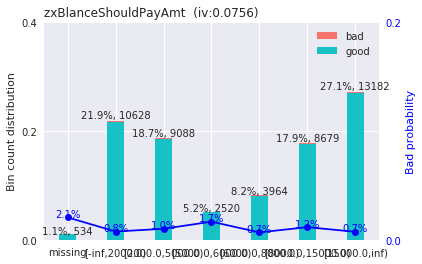

In [149]:
sc.woebin_plot(rf_bin_dicts,x=['zxBlanceShouldPayAmt'])

In [9]:
sc.woebin(train_x,y='tag',x='zxBlanceShouldPayAmt',breaks_list={'zxBlanceShouldPayAmt':[2000,5000,6000]})

NameError: name 'train_x' is not defined

In [155]:
'tag' in train_x.columns

False

## 2.4 按照IV值与badprob单调性筛选特征

In [43]:
# rf_bin_dicts.update(lab_bin_dicts)

In [142]:
all_bin_df_dicts = {**rf_bin_dicts,**lab_bin_dicts}
feas_info = fef.filter_fea(all_bin_df_dicts)

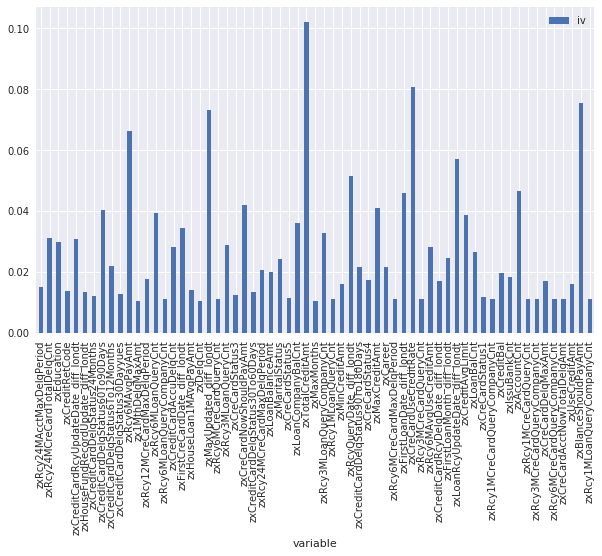

In [143]:
iv_drop_feas = set(feas_info[feas_info['iv'] <= 0.01].index)
sele_feas = set(feas_info.index)-iv_drop_feas
feas_info.reindex(sele_feas).plot.bar(figsize=(10,6))

In [144]:
train_x = train_x[sele_feas]
test_x = test_x[sele_feas]

## 2.5 特征woe编码

In [145]:
train_x_woe = sc.woebin_ply(train_x,rf_bin_dicts)
test_x_woe = sc.woebin_ply(test_x,rf_bin_dicts)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [147]:
train_x_woe

,zxCreCardStatus4,zxCreditRetCode,zxMaritalStatus,zxRcy24MAcctMaxDelqPeriod_woe,zxRcy24MCreCardTotalDelqCnt_woe,zxEducation_woe,zxMinCreditAmt_woe,zxRcyQueryDate_diff_londt_woe,zxCreditCardDelqStatus90To180Days_woe,zxCreditCardRcyUpdateDate_diff_londt_woe,zxHouseFundRecordUpdate_diff_londt_woe,zxMaxCreditAmt_woe,zxCreditCardDelqStatus24Months_woe,zxCareer_woe,zxCreditCardDelqStatus60To90Days_woe,zxCreditCardDelqStatus6To12Months_woe,zxRcy6MCreCardMaxDelqPeriod_woe,zxCreditCardDelqStatus30Dayyues_woe,zxRcy6MAvgPayAmt_woe,zxFirstLoanDate_diff_londt_woe,zx1MthDelqMaxAmt_woe,zxRcy12MCreCardMaxDelqPeriod_woe,zxRcy6MLoanQueryCnt_woe,zxRcy6MLoanQueryCompanyCnt_woe,zxCreCardUseCreditRate_woe,zxRcy3MCreCardQueryCnt_woe,zxCreditCardAccuDelqCnt_woe,zxFirstCreCardDate_diff_londt_woe,zxRcy6MAvgUseCreditAmt_woe,zxHouseLoan1MAvgPayAmt_woe,zxCreditCardRcyDelqDate_diff_londt_woe,zxDelqCnt_woe,zxMaxUpdated_diff_londt_woe,zxFirstLoanMonth_diff_londt_woe,zxRcy6MCreCardQueryCnt_woe,zxLoanRcyUpdateDate_diff_londt_woe,zxCreditAvgLimit_woe,zxRcy3MLoanQueryCnt_woe,zxCreCardStatus3_woe,zxCreCardNowShouldPayAmt_woe,zxCreditCardDelqStatus30To60Days_woe,zxRcy24MCreCardMaxDelqPeriod_woe,zxLoanBalCnt_woe,zxCreCardStatus1_woe,zxLoanBalanceAmt_woe,zxRcy1MCreCardQueryCompanyCnt_woe,zxCreditBal_woe,zxIssuBankCnt_woe,zxCreCardStatus5_woe,zxLoanCompanyBalCnt_woe,zxTotalCreditAmt_woe,zxAccountCnt_woe,zxRcy1MCreCardQueryCnt_woe,zxRcy3MCreCardQueryCompanyCnt_woe,zxCreCardDelqMaxAmt_woe,zxMaxMonths_woe,zxRcy6MCreCardQueryCompanyCnt_woe,zxCreCardAcctNowTotalDelqAmt_woe,zxRcy3MLoanQueryCompanyCnt_woe,zxUseCreditAmt_woe,zxBlanceShouldPayAmt_woe,zxRcy1MLoanQueryCnt_woe,zxRcy1MLoanQueryCompanyCnt_woe
0,3,0,0,-0.049233,-0.086762,-0.112960,-0.154500,-0.209181,-0.005856,-0.356596,-0.061861,-0.459605,-0.040596,-0.218661,-0.770778,-0.087285,-0.035545,-0.041220,0.261294,0.223632,-0.01335,0.163455,-0.269756,-0.013770,0.088407,-0.013770,0.168379,-0.111626,-0.117135,0.010239,0.129540,-0.01335,0.106625,0.253882,-0.013770,-0.298355,-0.188161,-0.162128,-0.034812,0.238053,-0.042846,0.130801,0.148801,-0.036660,0.012989,-0.013770,-0.068811,-0.048941,-0.130428,-0.136191,-0.130458,0.160510,-0.013770,-0.013770,0.117552,-0.01335,-0.013770,-0.035545,-0.162128,-0.062639,-0.234026,-0.013770,-0.013770
2,3,0,1,0.194885,-0.086762,-0.112960,0.045706,-0.209181,-0.005856,0.043607,-0.084046,-0.459605,-0.040596,0.098402,0.003797,-0.087285,-0.035545,-0.041220,0.261294,0.223632,-0.01335,-0.072803,0.013339,-0.013770,-0.569038,-0.013770,-0.337481,-0.227719,0.120042,0.010239,-0.347332,-0.01335,-0.473601,0.253882,-0.013770,-0.298355,-0.188161,-0.162128,-0.034812,-0.201028,-0.042846,-0.100569,-0.050895,-0.036660,0.012989,-0.013770,-0.068811,-0.048941,0.087183,-0.029682,-0.130458,-0.266325,-0.013770,-0.013770,-0.370911,-0.01335,-0.013770,-0.035545,-0.162128,-0.062639,0.228649,-0.013770,-0.013770
3,3,0,1,-0.049233,-0.086762,-0.112960,0.045706,-0.209181,-0.005856,0.055751,-0.021169,0.059099,-0.040596,0.098402,0.003797,-0.087285,-0.035545,-0.041220,-0.412665,-0.167648,-0.01335,-0.072803,0.109182,-0.013770,0.008057,-0.013770,-0.337481,0.160378,0.120042,0.010239,0.129540,-0.01335,0.301037,-0.124166,-0.013770,0.013790,-0.188161,0.073667,-0.034812,0.238053,-0.042846,-0.100569,-0.050895,-0.036660,0.012989,-0.013770,-0.068811,-0.048941,-0.130428,-0.029682,0.349098,0.160510,-0.013770,-0.013770,-0.370911,-0.01335,-0.013770,-0.035545,-0.156841,-0.062639,-0.198663,-0.013770,-0.013770
4,3,0,1,-0.049233,-0.086762,-0.112960,-0.154500,0.163221,-0.005856,0.043607,-0.021169,0.059099,-0.040596,0.098402,0.003797,-0.087285,-0.035545,-0.041220,0.254402,-0.318091,-0.01335,-0.072803,0.109182,-0.013770,0.088407,-0.013770,-0.042743,0.160378,0.120042,-0.127987,-0.008337,-0.01335,-0.187428,-0.073025,-0.013770,-0.006100,0.122318,-0.312114,-0.034812,0.238053,-0.042846,-0.100569,-0.493587,-0.036660,-0.232120,-0.013770,-0.068811,-0.048941,0.087183,0.200434,0.349098,-0.187100,-0.013770,-0.013770,-0.001344,-0.01335,-0.013770,-0.035545,0.328499

In [148]:
labsele_feas = sele_feas & set(labelencode_feas)
train_x_woe = sc.lab_woe_ply(train_x_woe,labsele_feas,lab_bin_dicts)
test_x_woe = sc.lab_woe_ply(test_x_woe,labsele_feas,lab_bin_dicts)

KeyError: "['zxEducation', 'zxCreditCardDelqStatus30Dayyues', 'zxCreditCardDelqStatus90To180Days', 'zxCreCardStatus3', 'zxCreditCardDelqStatus30To60Days', 'zxCreCardStatus1', 'zxCreditCardDelqStatus24Months', 'zxCareer', 'zxCreditCardDelqStatus60To90Days', 'zxCreditCardDelqStatus6To12Months', 'zxCreCardStatus5'] not in index"

## 2.6 相关性筛选

In [95]:
fs = FeatureSelector(train_x_woe,labels=train_y)
fs.identify_collinear(0.7)
fs_drop_feas = fs.check_removal()
train_x_woe.drop(fs_drop_feas,axis=1,inplace=True)
test_x_woe.drop(fs_drop_feas,axis=1,inplace=True)

21 features with a correlation magnitude greater than 0.70.

Total of 21 features identified for removal


## 2.6 逐步回归筛选特征

In [96]:
step_drop_feas,step_res = fef.step_logit(train_x_woe,train_y)

Optimization terminated successfully.
         Current function value: 0.052670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052616
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052580
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052580
         Iterations 9
                                Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.002    
Dependent Variable:      y                     AIC:                   5116.2691
Date:                    2021-02-02 14:52      BIC:                   5142.6429
No. Observations:        48595                 Log-Likelihood:        -2555.1  
Df Model:                2                     LL-Null:               -2559.5  
Df Residuals:            48592                 LLR p-value:           0.012781 
Converged:               1.0000                Scale:            

In [97]:
train_x_woe.drop(step_drop_feas,axis=1,inplace=True)
test_x_woe.drop(step_drop_feas,axis=1,inplace=True)

# 三、建立模型

## 3.1 逻辑回归

In [138]:
res = fef.step_logit(train_x_woe,train_y,selection='sample')

         Current function value: 0.052142
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
train_x_woe['_const'] = 1

In [ ]:
predict_train_y = res.predict(train_x_woe.values)

In [101]:
roc_auc_score(train_y,predict_train_y)

0.5367319374102378

In [99]:
bdmain.loc[:,bdmain.columns.str.contains('zxGuaranteeCnt')].count()

zxGuaranteeCnt    5
dtype: int64